Requisitos y **librer√≠as** necesarias:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import math
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

#### 1.1 Carga de datos y data wrangling

In [3]:
# Cargar los datos de los archivos
wd = pd.read_csv('WD.csv', decimal='.')
wdi = pd.read_csv('WDI.csv', decimal='.')
wgi = pd.read_csv('WGI.csv', decimal='.')

Inspecci√≥n de datos cargados: podemos inspeccionar un dato suelto para ver si est√° bien cargados

In [4]:
wdi.iloc[0]['2000 [YR2000]']

'8.054'

Vemos que a pesar de haberle forzado el decimal con el car√°cter . nos est√° interpretando los
n√∫meros como str, lo que es raro. Este es el primer indicador de que hay algo en las columnas
de variable que no est√° como deber√≠a. (Todas las variables son num√©ricas; no existen
variables categ√≥ricas)

In [5]:
# Inspeccionar las primeras filas de cada dataset
print("WD.csv - Datos de extensi√≥n, poblaci√≥n y densidad:")
wd.head()

WD.csv - Datos de extensi√≥n, poblaci√≥n y densidad:


Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4      Albania          ALB   

                                         Series Name Series Code  \
0                                 Land area (sq. km)   LAND_AREA   
1                                   Population total  POPULATION   
2  Population density (people per sq. km of land ...     DENSITY   
3                       Population growth (annual %)    POP_GROW   
4                                 Land area (sq. km)   LAND_AREA   

      2018 [YR2018]    2000 [YR2000]  
0            652230           652230  
1          36686784         19542982  
2  56.2482314520951  29.963328887049  
3  2.88520797304849  1.4438030241194  
4             27400            27400

In [6]:
print("WDI.csv - Indicadores de desarrollo:")
wdi.head()

WDI.csv - Indicadores de desarrollo:


Country Name Country Code                                  Series Name  \
0  Afghanistan          AFG  Unemployment total (% of total labor force)   
1  Afghanistan          AFG            Consumer price index (2010 = 100)   
2  Afghanistan          AFG                 Death rate (per 1000 people)   
3  Afghanistan          AFG           GDP per capita (constant 2015 US$)   
4  Afghanistan          AFG             Life expectancy at birth (years)   

   Series Code 2000 [YR2000]     2018 [YR2018]  
0     UNEMPLOY         8.054             11.11  
1          CPI            ..  146.522481857209  
2   DEATH_RATE        12.096             6.981  
3     GDP.PCAP            ..  578.985544847804  
4  LIFE_EXPECT        55.298            63.081

In [7]:
print("WGI.csv - Indicadores de gobernabilidad:")
wgi.head()

WGI.csv - Indicadores de gobernabilidad:


Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                         Series Name Series Code  \
0                    Control of Corruption: Estimate      CC.EST   
1              Control of Corruption: Standard Error  CC.STD.ERR   
2                 Government Effectiveness: Estimate      GE.EST   
3           Government Effectiveness: Standard Error  GE.STD.ERR   
4  Political Stability and Absence of Violence/Te...      PV.EST   

       2000 [YR2000]      2018 [YR2018]  
0  -1.27172422409058  -1.48977172374725  
1  0.346905559301376  0.155046001076698  
2  -2.17394614219666  -1.47929918766022  
3  0.331546425819397    0.2428357899189  
4  -2.43896889686584  -2.76386427879334

Vemos varios valores con .. en las cabeceras, que nos dicen que hay elementos no num√©ricos que est√°n impidiendo que las columnas se carguen como n√∫meros

Realizaremos la **integraci√≥n de los 3 datasets** para obtener una estructura coherente:

In [8]:
# Inspeccionar columnas relevantes
print("Columnas de WD:", wd.columns)
print("Columnas de WDI:", wdi.columns)
print("Columnas de WGI:", wgi.columns)

Columnas de WD: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2018 [YR2018]', '2000 [YR2000]'],
      dtype='object')
Columnas de WDI: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2000 [YR2000]', '2018 [YR2018]'],
      dtype='object')
Columnas de WGI: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2000 [YR2000]', '2018 [YR2018]'],
      dtype='object')


In [9]:
# Realizar una unificaci√≥n inicial basada en el nombre del pa√≠s
merged_data = pd.merge(wd, wdi, how="outer")
merged_data = pd.merge(merged_data, wgi, how="outer")

In [10]:
# Inspeccionar el dataset unificado
print("Dataset unificado:\n")
merged_data.head()

Dataset unificado:



Country Name Country Code                            Series Name  \
0  Afghanistan          AFG      Consumer price index (2010 = 100)   
1  Afghanistan          AFG        Control of Corruption: Estimate   
2  Afghanistan          AFG  Control of Corruption: Standard Error   
3  Afghanistan          AFG           Death rate (per 1000 people)   
4  Afghanistan          AFG     GDP per capita (constant 2015 US$)   

  Series Code      2018 [YR2018]      2000 [YR2000]  
0         CPI   146.522481857209                 ..  
1      CC.EST  -1.48977172374725  -1.27172422409058  
2  CC.STD.ERR  0.155046001076698  0.346905559301376  
3  DEATH_RATE              6.981             12.096  
4    GDP.PCAP   578.985544847804                 ..

Vamos a intentar solucionar los problemas de los datos num√©ricos, convertimos los datos a num√©ricos:

In [11]:
try:
    result = pd.to_numeric(merged_data['2018 [YR2018]'], errors='raise')
    print("Resultado parcial de la conversi√≥n:\n", result.head())
except Exception as e:
    print(f"Error durante la conversi√≥n: {e}")

Error durante la conversi√≥n: Unable to parse string ".." at position 22


Como vemos, al intentarlo, obtenemos un error que nos dice que el sistema no es capaz, ya que encuentra un valor .. en la posici√≥n 22. Como ya vemos que hay caracteres inesperados, debemos convertir √©stos a NaN para poder seguir. Para ello, basta con utilizar el argumento coerce de la funci√≥n .to_numeric, que convierte en NaN los valores que no es capaz de manejar en la conversi√≥n a n√∫meros:

In [12]:
# Convertir a num√©ricas las columnas de datos
merged_data['2018 [YR2018]'] = pd.to_numeric(merged_data['2018 [YR2018]'], errors='coerce')
merged_data['2000 [YR2000]'] = pd.to_numeric(merged_data['2000 [YR2000]'], errors='coerce')

In [13]:
# Visualizar los datos
merged_data.head()

Country Name Country Code                            Series Name  \
0  Afghanistan          AFG      Consumer price index (2010 = 100)   
1  Afghanistan          AFG        Control of Corruption: Estimate   
2  Afghanistan          AFG  Control of Corruption: Standard Error   
3  Afghanistan          AFG           Death rate (per 1000 people)   
4  Afghanistan          AFG     GDP per capita (constant 2015 US$)   

  Series Code  2018 [YR2018]  2000 [YR2000]  
0         CPI     146.522482            NaN  
1      CC.EST      -1.489772      -1.271724  
2  CC.STD.ERR       0.155046       0.346906  
3  DEATH_RATE       6.981000      12.096000  
4    GDP.PCAP     578.985545            NaN

Realizamos un primer fundido de los datos anuales a la columna Year, manteniendo el resto igual:

In [14]:
melted_data = pd.melt(merged_data, id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'], var_name="Year", value_name="Variable Value")
melted_data

Country Name Country Code                                  Series Name  \
0      Afghanistan          AFG            Consumer price index (2010 = 100)   
1      Afghanistan          AFG              Control of Corruption: Estimate   
2      Afghanistan          AFG        Control of Corruption: Standard Error   
3      Afghanistan          AFG                 Death rate (per 1000 people)   
4      Afghanistan          AFG           GDP per capita (constant 2015 US$)   
...            ...          ...                                          ...   
11699     Zimbabwe          ZWE                        Rule of Law: Estimate   
11700     Zimbabwe          ZWE                  Rule of Law: Standard Error   
11701     Zimbabwe          ZWE  Unemployment total (% of total labor force)   
11702     Zimbabwe          ZWE           Voice and Accountability: Estimate   
11703     Zimbabwe          ZWE     Voice and Accountability: Standard Error   

      Series Code           Year  Variable Value  
0             CPI  2018 [YR2018]      146.522482  
1          CC.EST  2018 [YR2018]       -1.489772  
2      CC.STD.ERR  2018 [YR2018]        0.155046  
3      DEATH_RATE  2018 [YR2018]        6.981000  
4        GDP.PCAP  2018 [YR2018]      578.985545  
...           ...            ...             ...  
11699      RL.EST  2000 [YR2000]       -1.381908  
11700  RL.STD.ERR  2000 [YR2000]        0.170140  
11701    UNEMPLOY  2000 [YR2000]        5.688000  
11702      VA.EST  2000 [YR2000]       -1.085388  
11703  VA.STD.ERR  2000 [YR2000]        0.192938  

[11704 rows x 6 columns]

Para lograr la estructura pedida, haremos un pivot de la tabla, para transformar los pares de valores actuales de Series Code y Variable Value en claves de columna - valores. Para ello, hay que eliminar primero Series Name:

In [15]:
# Eliminar la columna
melted_data = melted_data.drop(columns='Series Name')

In [16]:
# Pivotar el dataset
tidy_data = pd.pivot(melted_data, index=['Country Name', 'Country Code','Year'], columns='Series Code', values='Variable Value')

In [17]:
# Resetear el √≠ndice tras el pivot
tidy_data = tidy_data.reset_index()
tidy_data['CC.STD.ERR'].iloc[0]

0.346905559301376

In [18]:
# Guardar el dataset final para futuras operaciones
tidy_data.to_csv("tidy_dataset.csv", index=False)
print("Dataset limpio guardado como tidy_dataset.csv")

Dataset limpio guardado como tidy_dataset.csv


La estructura seleccionada proporciona una vista unificada y relacional de los datos provenientes de m√∫ltiples fuentes (WD, WDI, y WGI). Esto facilita:
1. An√°lisis Comparativo: al tener los indicadores socioecon√≥micos y de gobernabilidad en un solo dataset, se pueden establecer comparaciones directas y relaciones entre las variables.
2. Estandarizaci√≥n: la integraci√≥n bajo una clave com√∫n, como el nombre del pa√≠s, permite evitar redundancias y consolidar la informaci√≥n dispersa.
3. Preparaci√≥n para Data Mining: los m√©todos de miner√≠a de datos requieren estructuras bien organizadas y consistentes, lo que esta estructura permite.
4. Flexibilidad Anal√≠tica: la estructura simplificada facilita la generaci√≥n de gr√°ficos, estad√≠sticas y modelos, sin necesidad de m√∫ltiples cruces durante el an√°lisis.

#### 1.2 Tratamiento de datos faltantes, an√≥malos y err√≥neos

In [19]:
# Calcular el porcentaje de valores faltantes por columna
missing_data = tidy_data.isnull().mean() * 100
print("Porcentaje de valores faltantes por columna:\n")
print(missing_data, "\n")
missing_data = tidy_data.isnull().sum()
print("N√∫mero de valores faltantes por columna:\n")
print(missing_data, "\n")

Porcentaje de valores faltantes por columna:

Series Code
Country Name     0.000000
Country Code     0.000000
Year             0.000000
BIRTH_MORT       8.955224
CC.EST          27.425373
CC.STD.ERR      27.425373
CPI             35.447761
DEATH_RATE       2.425373
DENSITY          2.238806
GDP.PCAP         7.462687
GE.EST          28.358209
GE.STD.ERR      28.358209
LAND_AREA        2.238806
LIFE_EXPECT      3.731343
POPULATION       1.119403
POP_GROW         1.119403
PV.EST          26.865672
PV.STD.ERR      26.865672
RL.EST          25.000000
RL.STD.ERR      25.000000
RQ.EST          28.171642
RQ.STD.ERR      28.171642
UNEMPLOY        12.313433
VA.EST          25.000000
VA.STD.ERR      25.000000
dtype: float64 

N√∫mero de valores faltantes por columna:

Series Code
Country Name      0
Country Code      0
Year              0
BIRTH_MORT       48
CC.EST          147
CC.STD.ERR      147
CPI             190
DEATH_RATE       13
DENSITY          12
GDP.PCAP         40
GE.EST          152


Vemos que tenemos un porcentaje apreciable de datos faltantes en algunas variables, llegando incluso a valores cercanos al 30%. Hay muchas posibilidades en este apartado: 
1. Se debe hacer un an√°lisis de que ciertas columnas o ciertas filas tienen demasiados pocos datos reales, y se debe considerar su eliminaci√≥n √≠ntegra de las mismas.
2. Para variables no eliminadas, al ser todas num√©ricas y continuas, se puede hacer imputaci√≥n. Se pueden usar muchas t√©cnicas; desde utilizar la mediana hasta buscar semejanzas geogr√°ficas o utilizar K-Means.

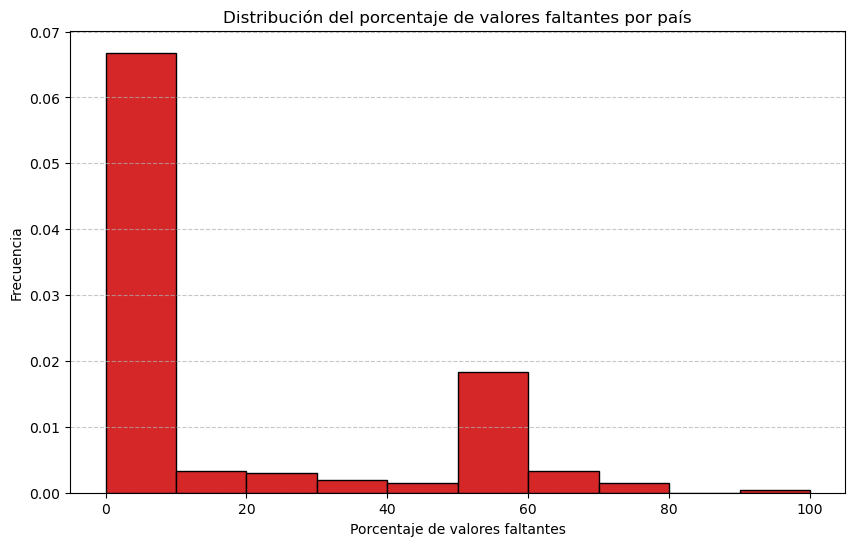

In [20]:
# Calcular el porcentaje de valores faltantes por pa√≠s
nan_percentage_by_country = tidy_data.groupby('Country Name').apply(lambda x: x.isnull().sum().sum() / x.size * 100, include_groups=False)
bins = np.arange(0, nan_percentage_by_country.max() + 10, 10)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(nan_percentage_by_country, bins=bins, color='tab:red', edgecolor='black', density=True)
plt.title('Distribuci√≥n del porcentaje de valores faltantes por pa√≠s')
plt.xlabel('Porcentaje de valores faltantes')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Vemos que hay unos pocos paises con much√≠simos datos faltantes, ya que la gran mayor√≠a tienen menos del 60% de NaN

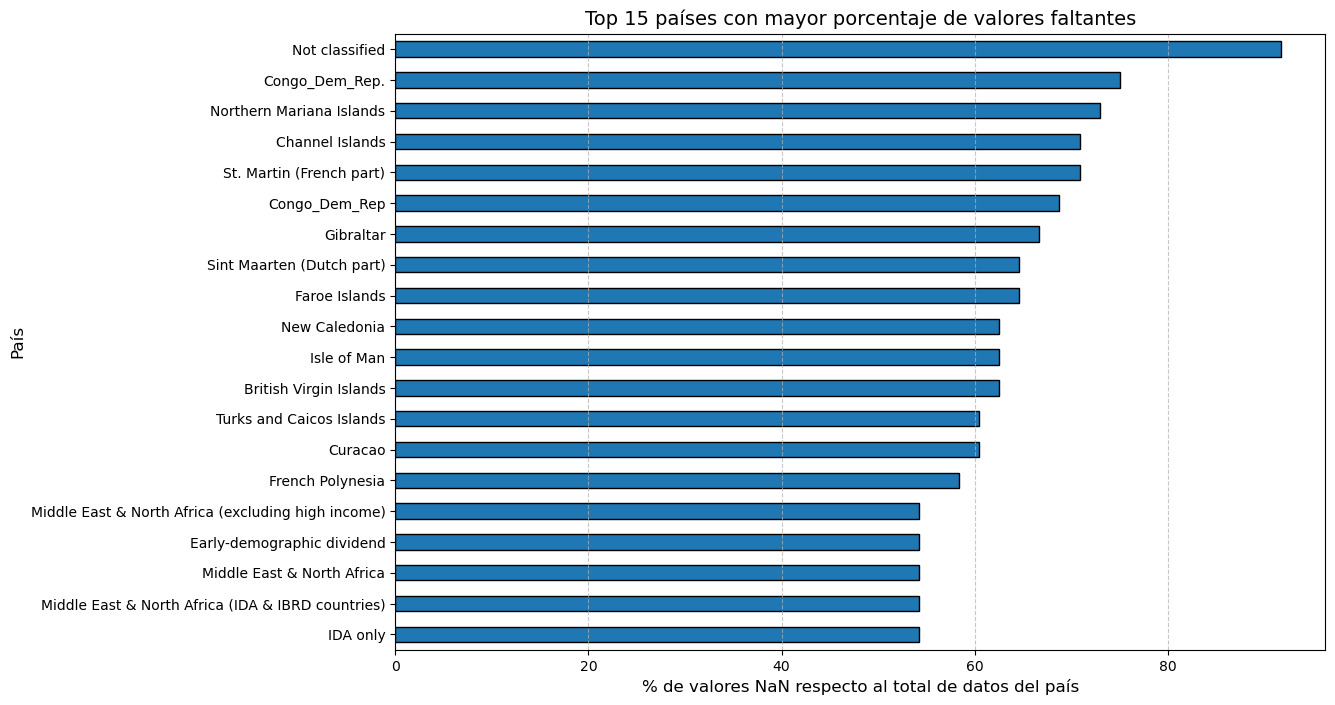

In [21]:
# Ordenar los pa√≠ses por porcentaje de valores NaN
nan_percentage_sorted = nan_percentage_by_country.sort_values(ascending=False)

# Seleccionar los top 15 pa√≠ses con m√°s valores NaN
top_countries = nan_percentage_sorted.head(20)

# Crear un gr√°fico de barras
plt.figure(figsize=(12, 8))
top_countries.plot(kind='barh', color='tab:blue', edgecolor='black')
plt.title('Top 15 pa√≠ses con mayor porcentaje de valores faltantes', fontsize=14)
plt.xlabel('% de valores NaN respecto al total de datos del pa√≠s', fontsize=12)
plt.ylabel('Pa√≠s', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis() # Invertir el eje Y para mostrar el pa√≠s con m√°s NaNs arriba
plt.show()

In [22]:
# Identificar los pa√≠ses con m√°s del 25% de valores faltantes
countries_to_remove = nan_percentage_by_country[nan_percentage_by_country > 60].index

# Contar cu√°ntos pa√≠ses ser√°n eliminados
num_countries_removed = len(countries_to_remove)
print(f"N√∫mero de pa√≠ses eliminados: {num_countries_removed}")

# Filtrar el dataset para eliminar esos pa√≠ses
filtered_data = tidy_data[~tidy_data['Country Name'].isin(countries_to_remove)]

# Confirmar el nuevo tama√±o del dataset
print(f"Tama√±o del dataset despu√©s de eliminar pa√≠ses: {filtered_data.shape}")

N√∫mero de pa√≠ses eliminados: 14
Tama√±o del dataset despu√©s de eliminar pa√≠ses: (508, 25)


Para el resto de valores faltantes usaremos **KNN**

In [24]:
# Paso 1: seleccionar solo las columnas num√©ricas para imputar
numeric_columns = filtered_data.select_dtypes(include=['float64', 'int64']).columns

# Paso 2: escalar los datos para evitar problemas de magnitudes
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data[numeric_columns])

# Paso 3: imputar valores faltantes utilizando KNN (KNNImputer en sklearn)
imputer = KNNImputer(n_neighbors=5) 
imputed_data = imputer.fit_transform(scaled_data)

# Paso 4: restaurar el DataFrame original con los valores imputados
imputed_df = filtered_data.copy()
imputed_df[numeric_columns] = scaler.inverse_transform(imputed_data)

# Verificar si hay valores faltantes despu√©s de la imputaci√≥n
remaining_na = imputed_df.isnull().sum().sum()
print(f"Valores faltantes restantes despu√©s de la imputaci√≥n: {remaining_na}")

Valores faltantes restantes despu√©s de la imputaci√≥n: 0


**Detecci√≥n y gesti√≥n de outliers**: hay muchas opciones (M√©todo del Rango Intercuart√≠lico (IQR) - Distribuci√≥n Gaussiana (Z-score) - An√°lisis Multivariado). En cualquier caso, se deben excluir las variables de tipo geogr√°fico, como la poblaci√≥n o la superficie, ya que son m√©tricas con una divisi√≥n completamente artificial, y a priori deben excluirse las columnas con desviaciones t√≠picas

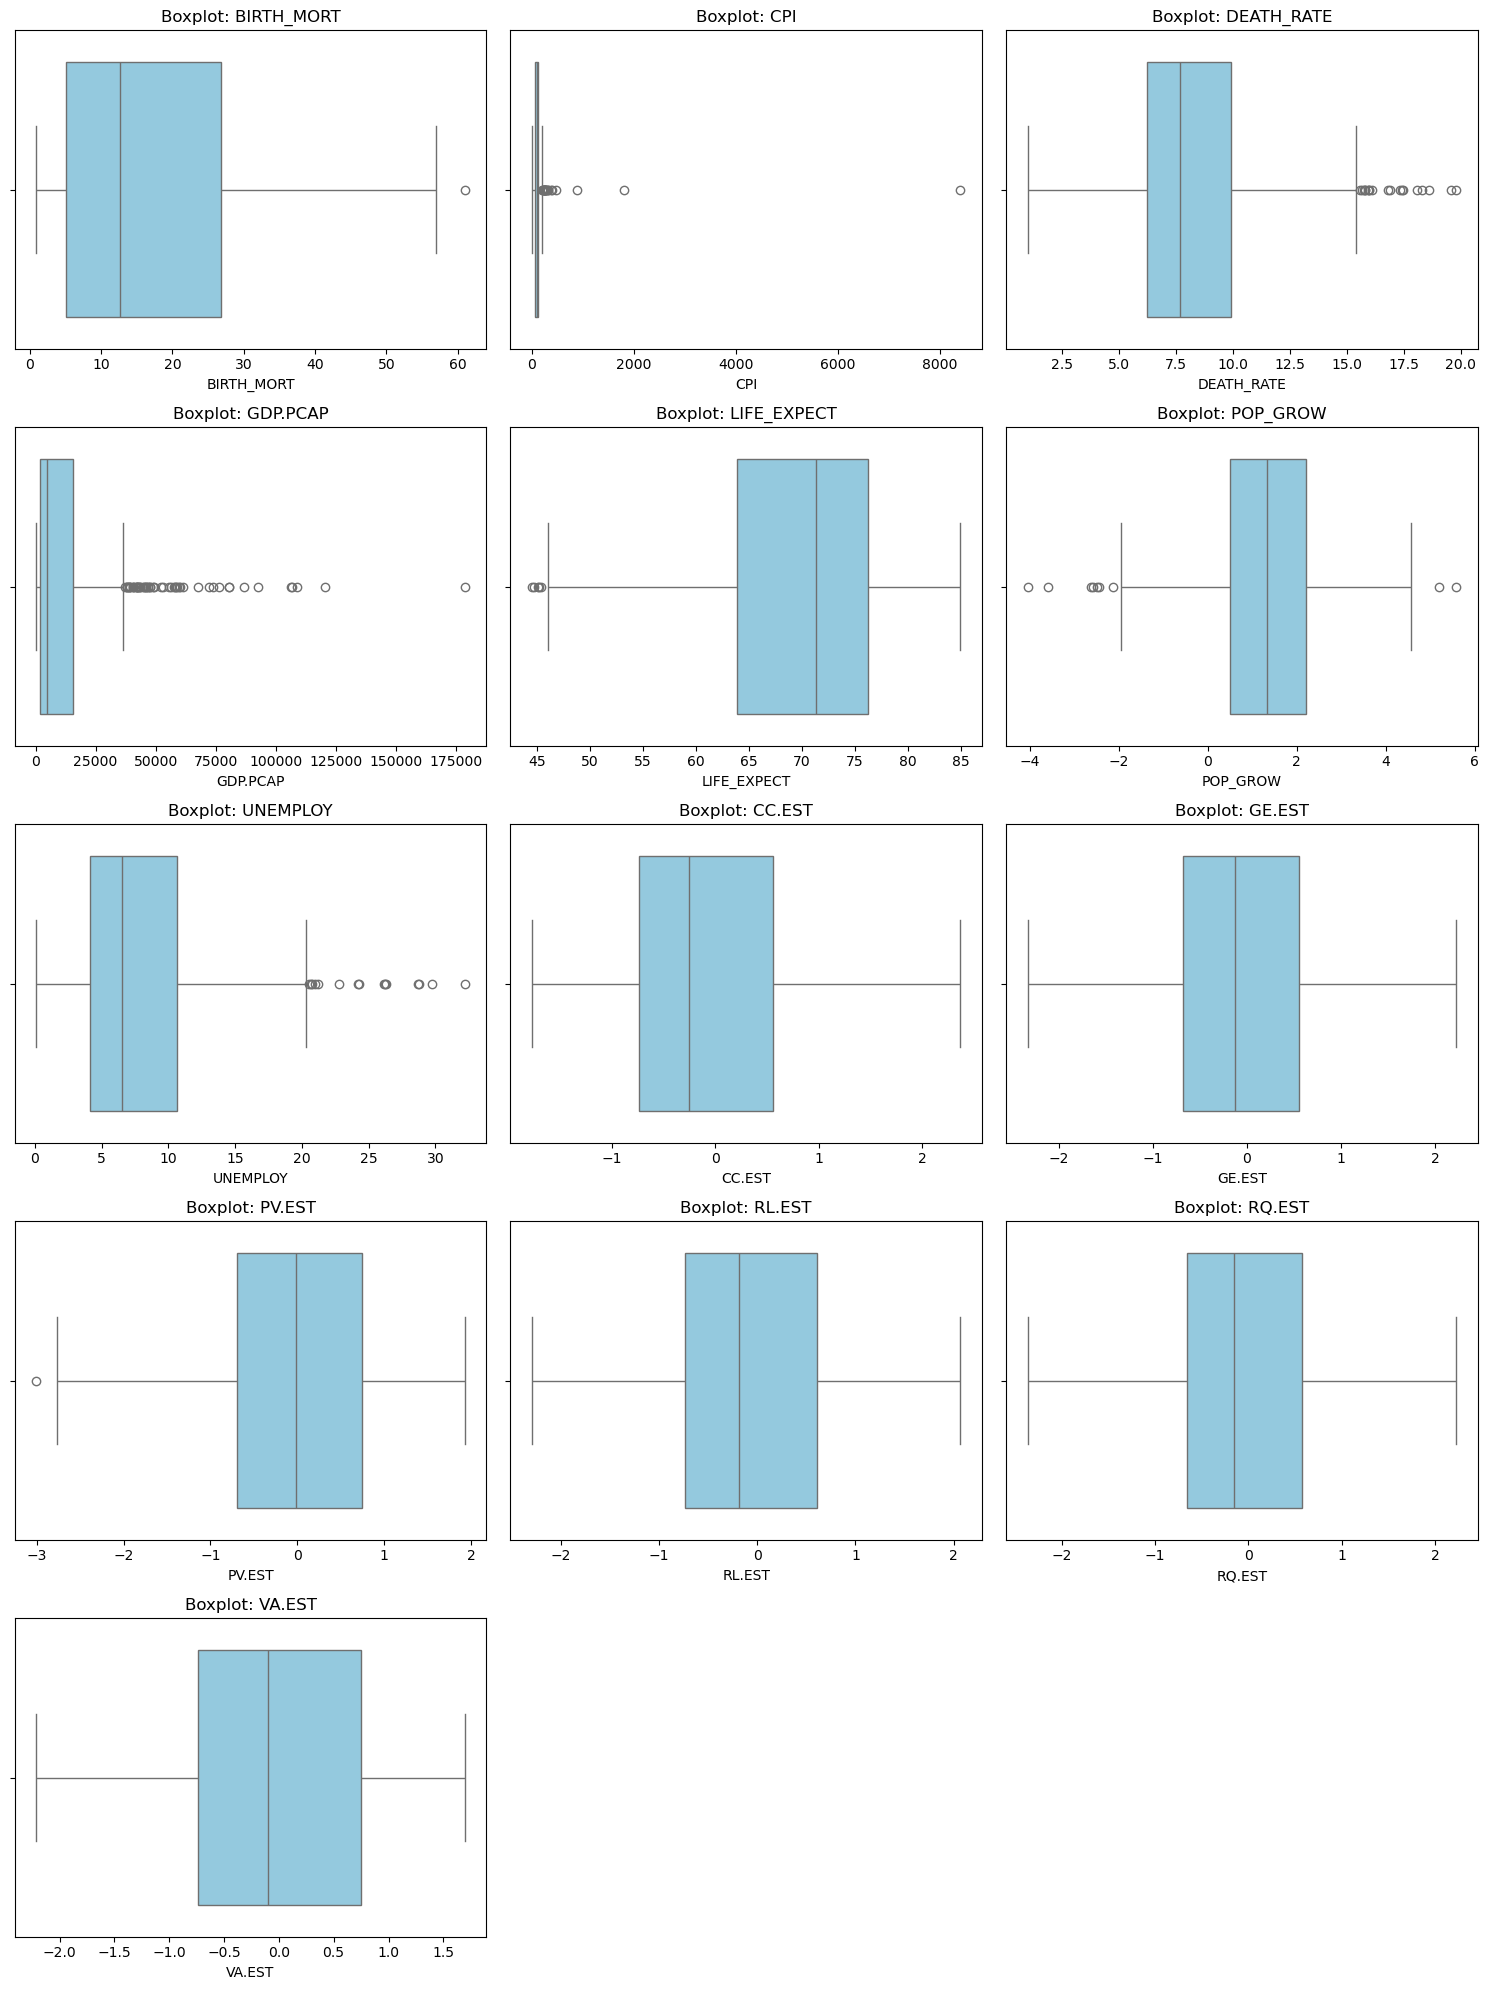

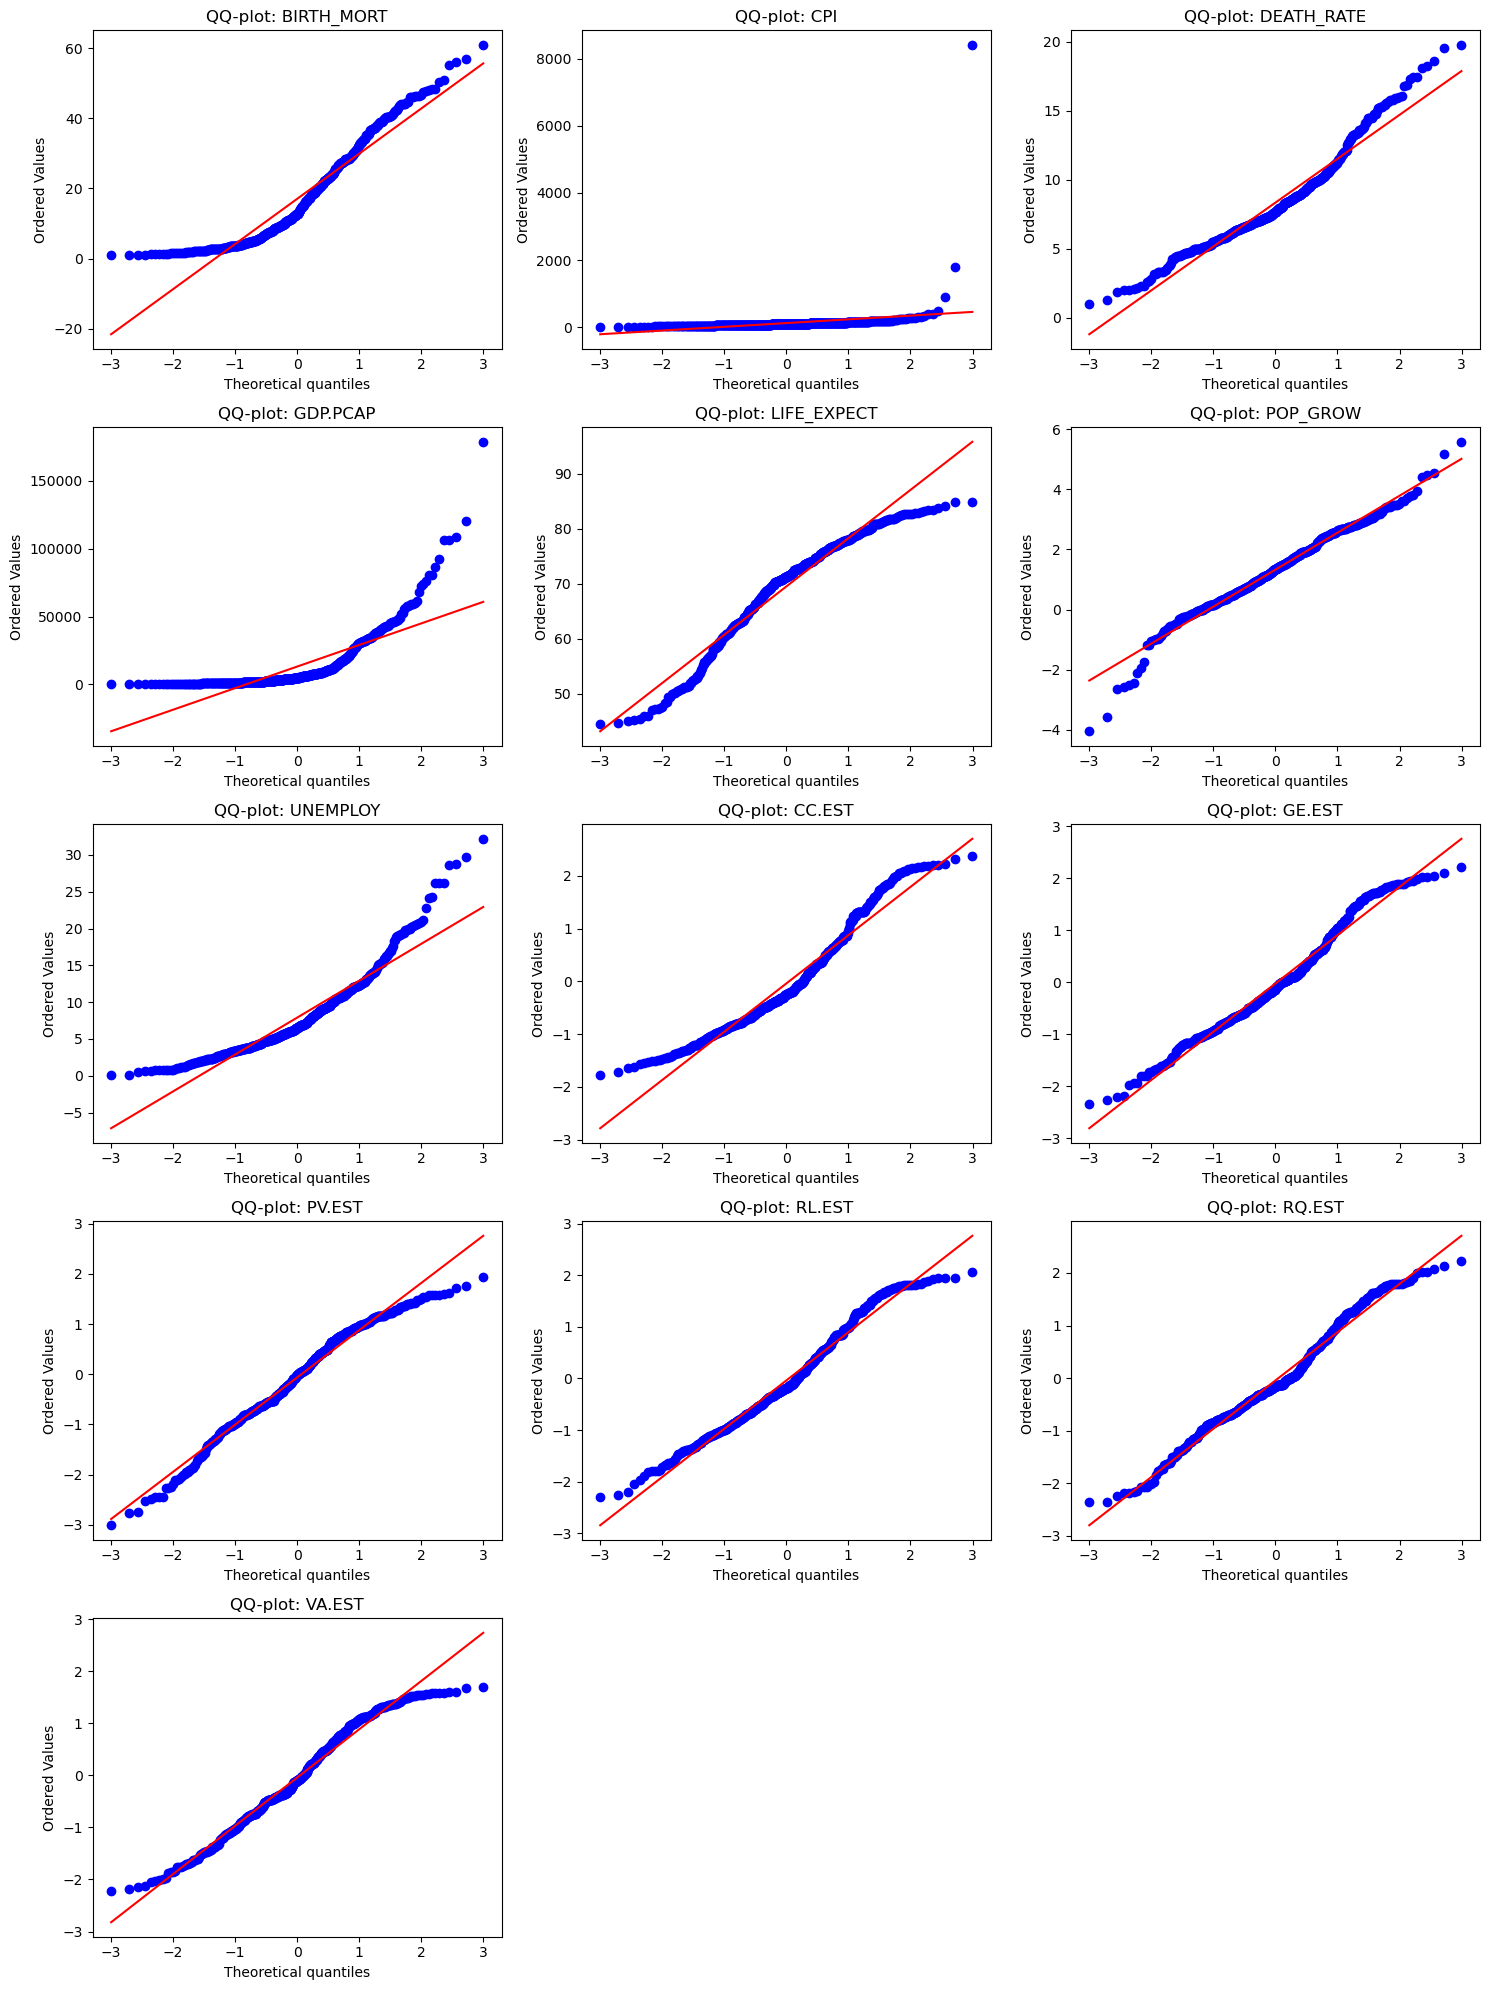

In [25]:
# Lista de columnas seleccionadas (excluyendo las .STD.ERR y variables geogr√°ficas)
reasonable_columns = [
'BIRTH_MORT', 'CPI', 'DEATH_RATE', 'GDP.PCAP',
'LIFE_EXPECT', 'POP_GROW', 'UNEMPLOY',
'CC.EST', 'GE.EST', 'PV.EST', 'RL.EST', 'RQ.EST', 'VA.EST'
]

# Determinar el n√∫mero de filas y columnas para subplots
num_vars = len(reasonable_columns)
cols = 3 # N√∫mero de columnas deseado
rows = math.ceil(num_vars / cols)

# Paso 1: Crear boxplots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=imputed_df[col], color='skyblue')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# Paso 2: Crear QQ-plots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    stats.probplot(imputed_df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ-plot: {col}")
    
plt.tight_layout()
plt.show()

Los QQ-Plots parecen bastante normales, con alg√∫n dato claramente sin sentido, proablemente procedente de la elecci√≥n arbitraria de los ùêæ en K-Means, o bien procedente del dataset original. Podemos probar a normalizar las variables:

In [26]:
# Funci√≥n para detectar y tratar outliers mediante normalizaci√≥n (z-scores)
def detect_and_count_outliers_zscore(df, column, threshold=3):

    # Calcular el z-score para la columna
    z_scores = zscore(df[column].dropna())
    outliers = (z_scores > threshold) | (z_scores < -threshold)

    # Contar valores fuera de los l√≠mites
    below_lower = (z_scores < -threshold).sum()
    above_upper = (z_scores > threshold).sum()
    total_outliers = below_lower + above_upper

    # Winsorizaci√≥n basada en z-scores
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return total_outliers, below_lower, above_upper

# Aplicar el tratamiento y contar outliers en cada columna razonable
outliers_summary_zscore = {}
for col in reasonable_columns:
    total_outliers, below_lower, above_upper = detect_and_count_outliers_zscore(imputed_df, col)
    outliers_summary_zscore[col] = {
        'total_outliers': total_outliers,
        'below_lower': below_lower,
        'above_upper': above_upper
    }
    print(f"Columna: {col}")
    print(f" Outliers totales: {total_outliers}")
    print(f" Por debajo del l√≠mite inferior: {below_lower}")
    print(f" Por encima del l√≠mite superior: {above_upper}\n")

# Resumen final
print("\nResumen de outliers tratados mediante normalizaci√≥n:")
for col, counts in outliers_summary_zscore.items():
    print(f"{col}: {counts['total_outliers']} outliers (Inferior: {counts['below_lower']}, Superior: {counts['above_upper']})")

Columna: BIRTH_MORT
 Outliers totales: 1
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 1

Columna: CPI
 Outliers totales: 2
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 2

Columna: DEATH_RATE
 Outliers totales: 5
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 5

Columna: GDP.PCAP
 Outliers totales: 11
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 11

Columna: LIFE_EXPECT
 Outliers totales: 0
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 0

Columna: POP_GROW
 Outliers totales: 8
 Por debajo del l√≠mite inferior: 6
 Por encima del l√≠mite superior: 2

Columna: UNEMPLOY
 Outliers totales: 9
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 9

Columna: CC.EST
 Outliers totales: 0
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 0

Columna: GE.EST
 Outliers totales: 0
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite super

In [27]:
# Funci√≥n para detectar y tratar outliers con IQR, registrando la cantidad tratada
def detect_and_count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar valores fuera de los l√≠mites
    below_lower = df[column][df[column] < lower_bound].count()
    above_upper = df[column][df[column] > upper_bound].count()
    total_outliers = below_lower + above_upper

    # Winsorizaci√≥n: Limitar los valores extremos a los l√≠mites
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return total_outliers, below_lower, above_upper
    
# Aplicar el tratamiento y contar outliers en cada columna razonable
outliers_summary = {}
for col in reasonable_columns:
    total_outliers, below_lower, above_upper = detect_and_count_outliers(imputed_df, col)
    outliers_summary[col] = {
        'total_outliers': total_outliers,
        'below_lower': below_lower,
        'above_upper': above_upper
    }
    print(f"Columna: {col}")
    print(f" Outliers totales: {total_outliers}")
    print(f" Por debajo del l√≠mite inferior: {below_lower}")
    print(f" Por encima del l√≠mite superior: {above_upper}\n")

# Resumen final
print("\nResumen de outliers tratados:")
for col, counts in outliers_summary.items():
    print(f"{col}: {counts['total_outliers']} outliers (Inferior: {counts['below_lower']}, Superior: {counts['above_upper']})")

Columna: BIRTH_MORT
 Outliers totales: 0
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 0

Columna: CPI
 Outliers totales: 21
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 21

Columna: DEATH_RATE
 Outliers totales: 19
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 19

Columna: GDP.PCAP
 Outliers totales: 54
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 54

Columna: LIFE_EXPECT
 Outliers totales: 5
 Por debajo del l√≠mite inferior: 5
 Por encima del l√≠mite superior: 0

Columna: POP_GROW
 Outliers totales: 9
 Por debajo del l√≠mite inferior: 7
 Por encima del l√≠mite superior: 2

Columna: UNEMPLOY
 Outliers totales: 15
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 15

Columna: CC.EST
 Outliers totales: 0
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite superior: 0

Columna: GE.EST
 Outliers totales: 0
 Por debajo del l√≠mite inferior: 0
 Por encima del l√≠mite

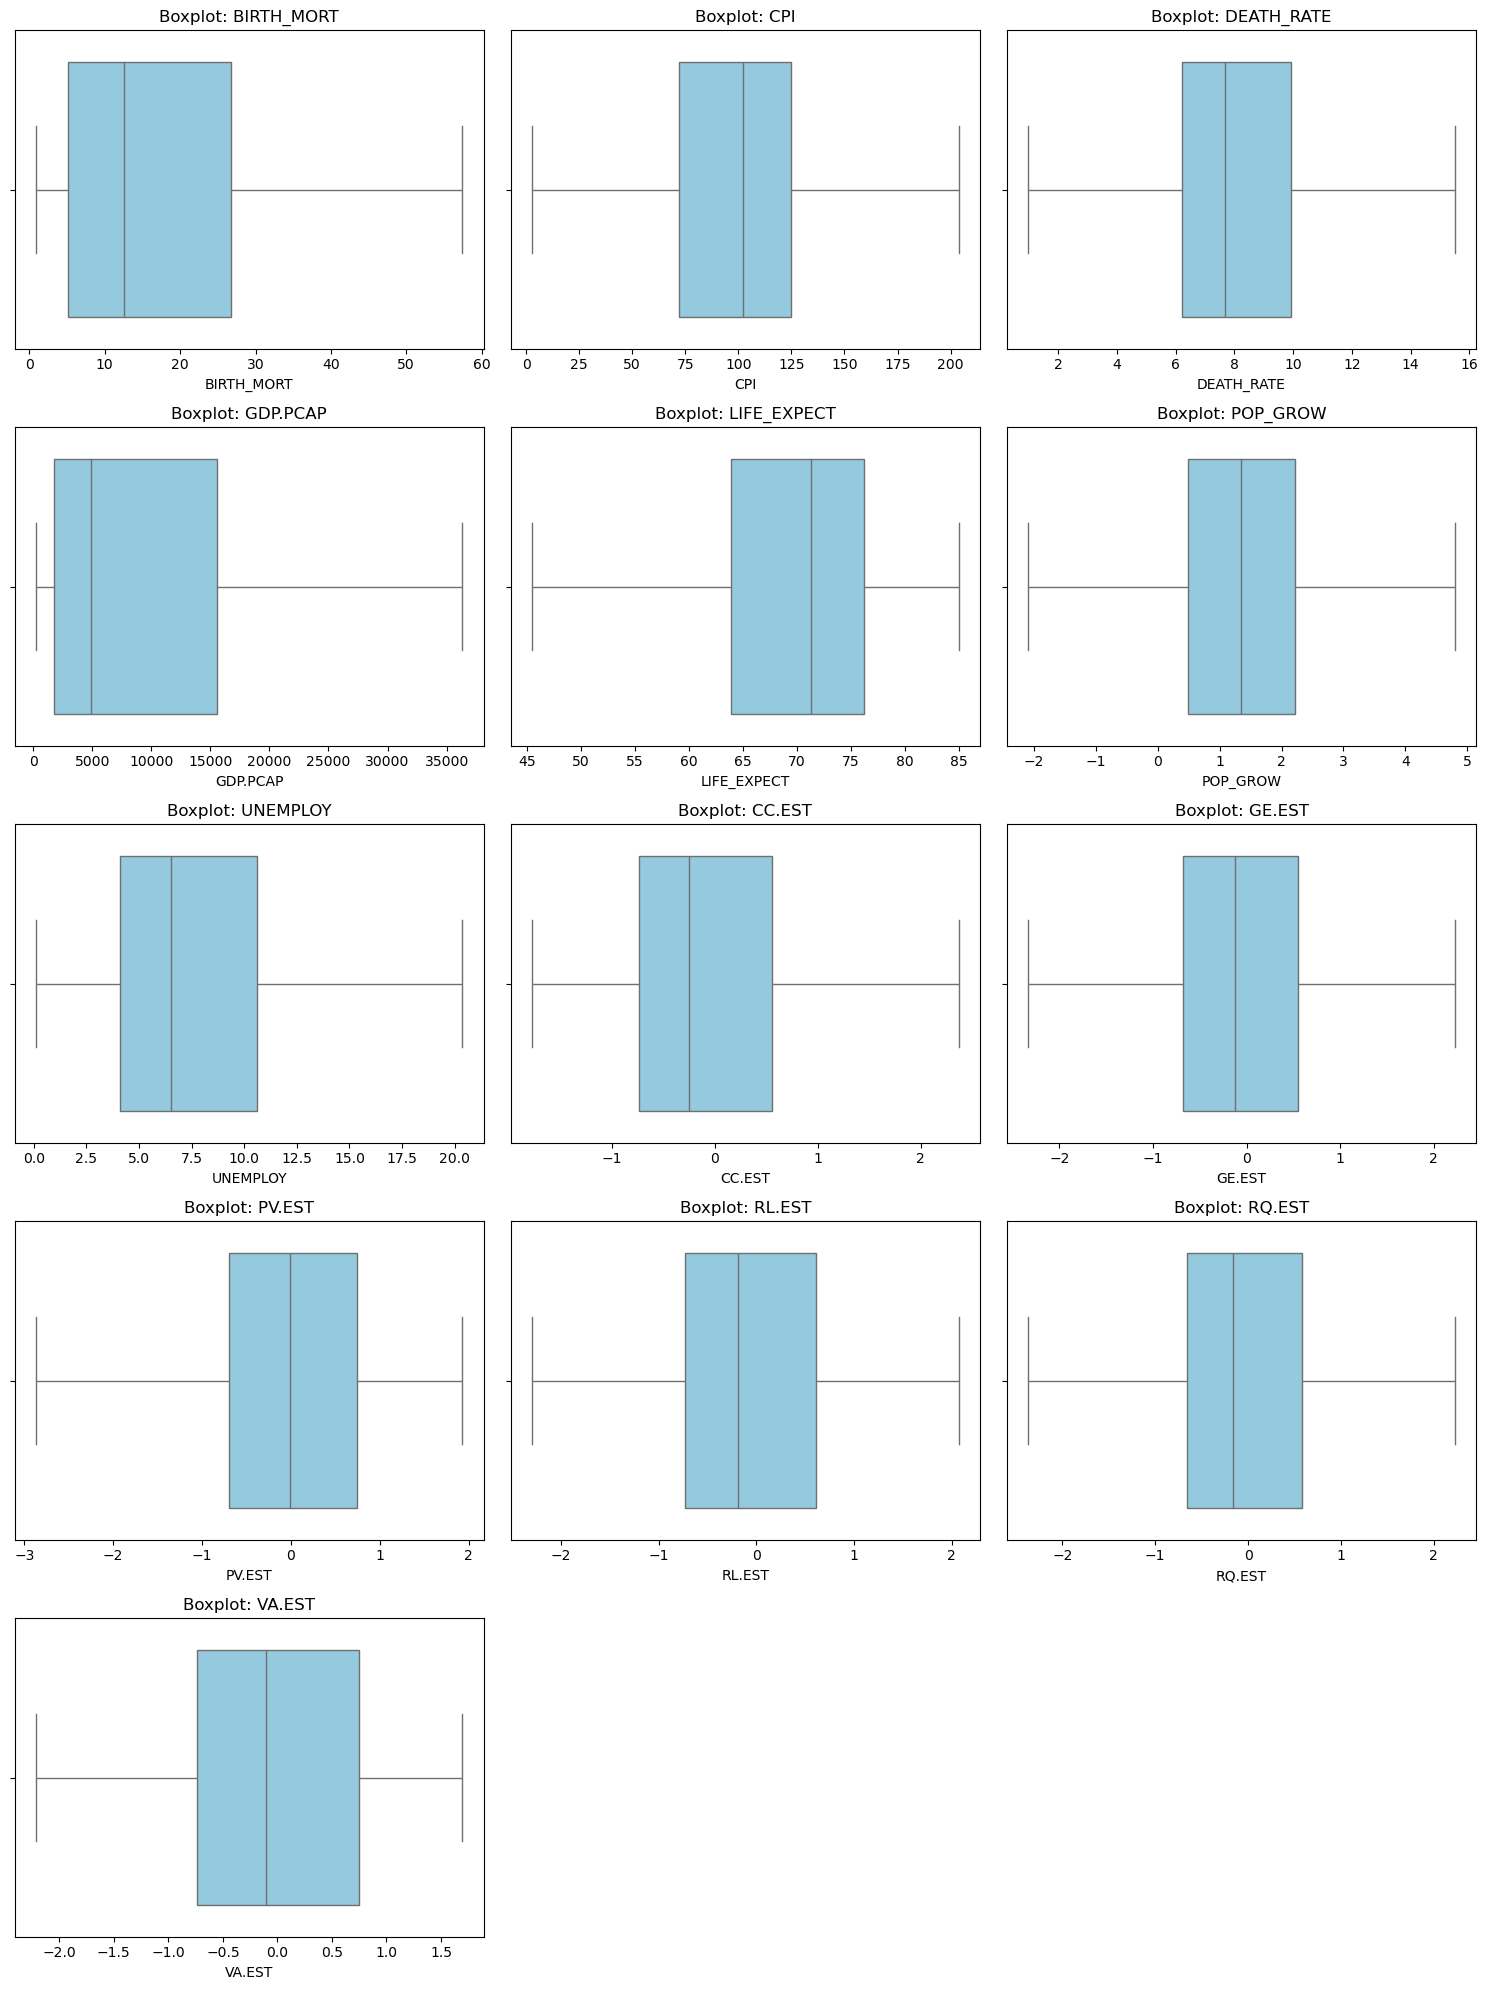

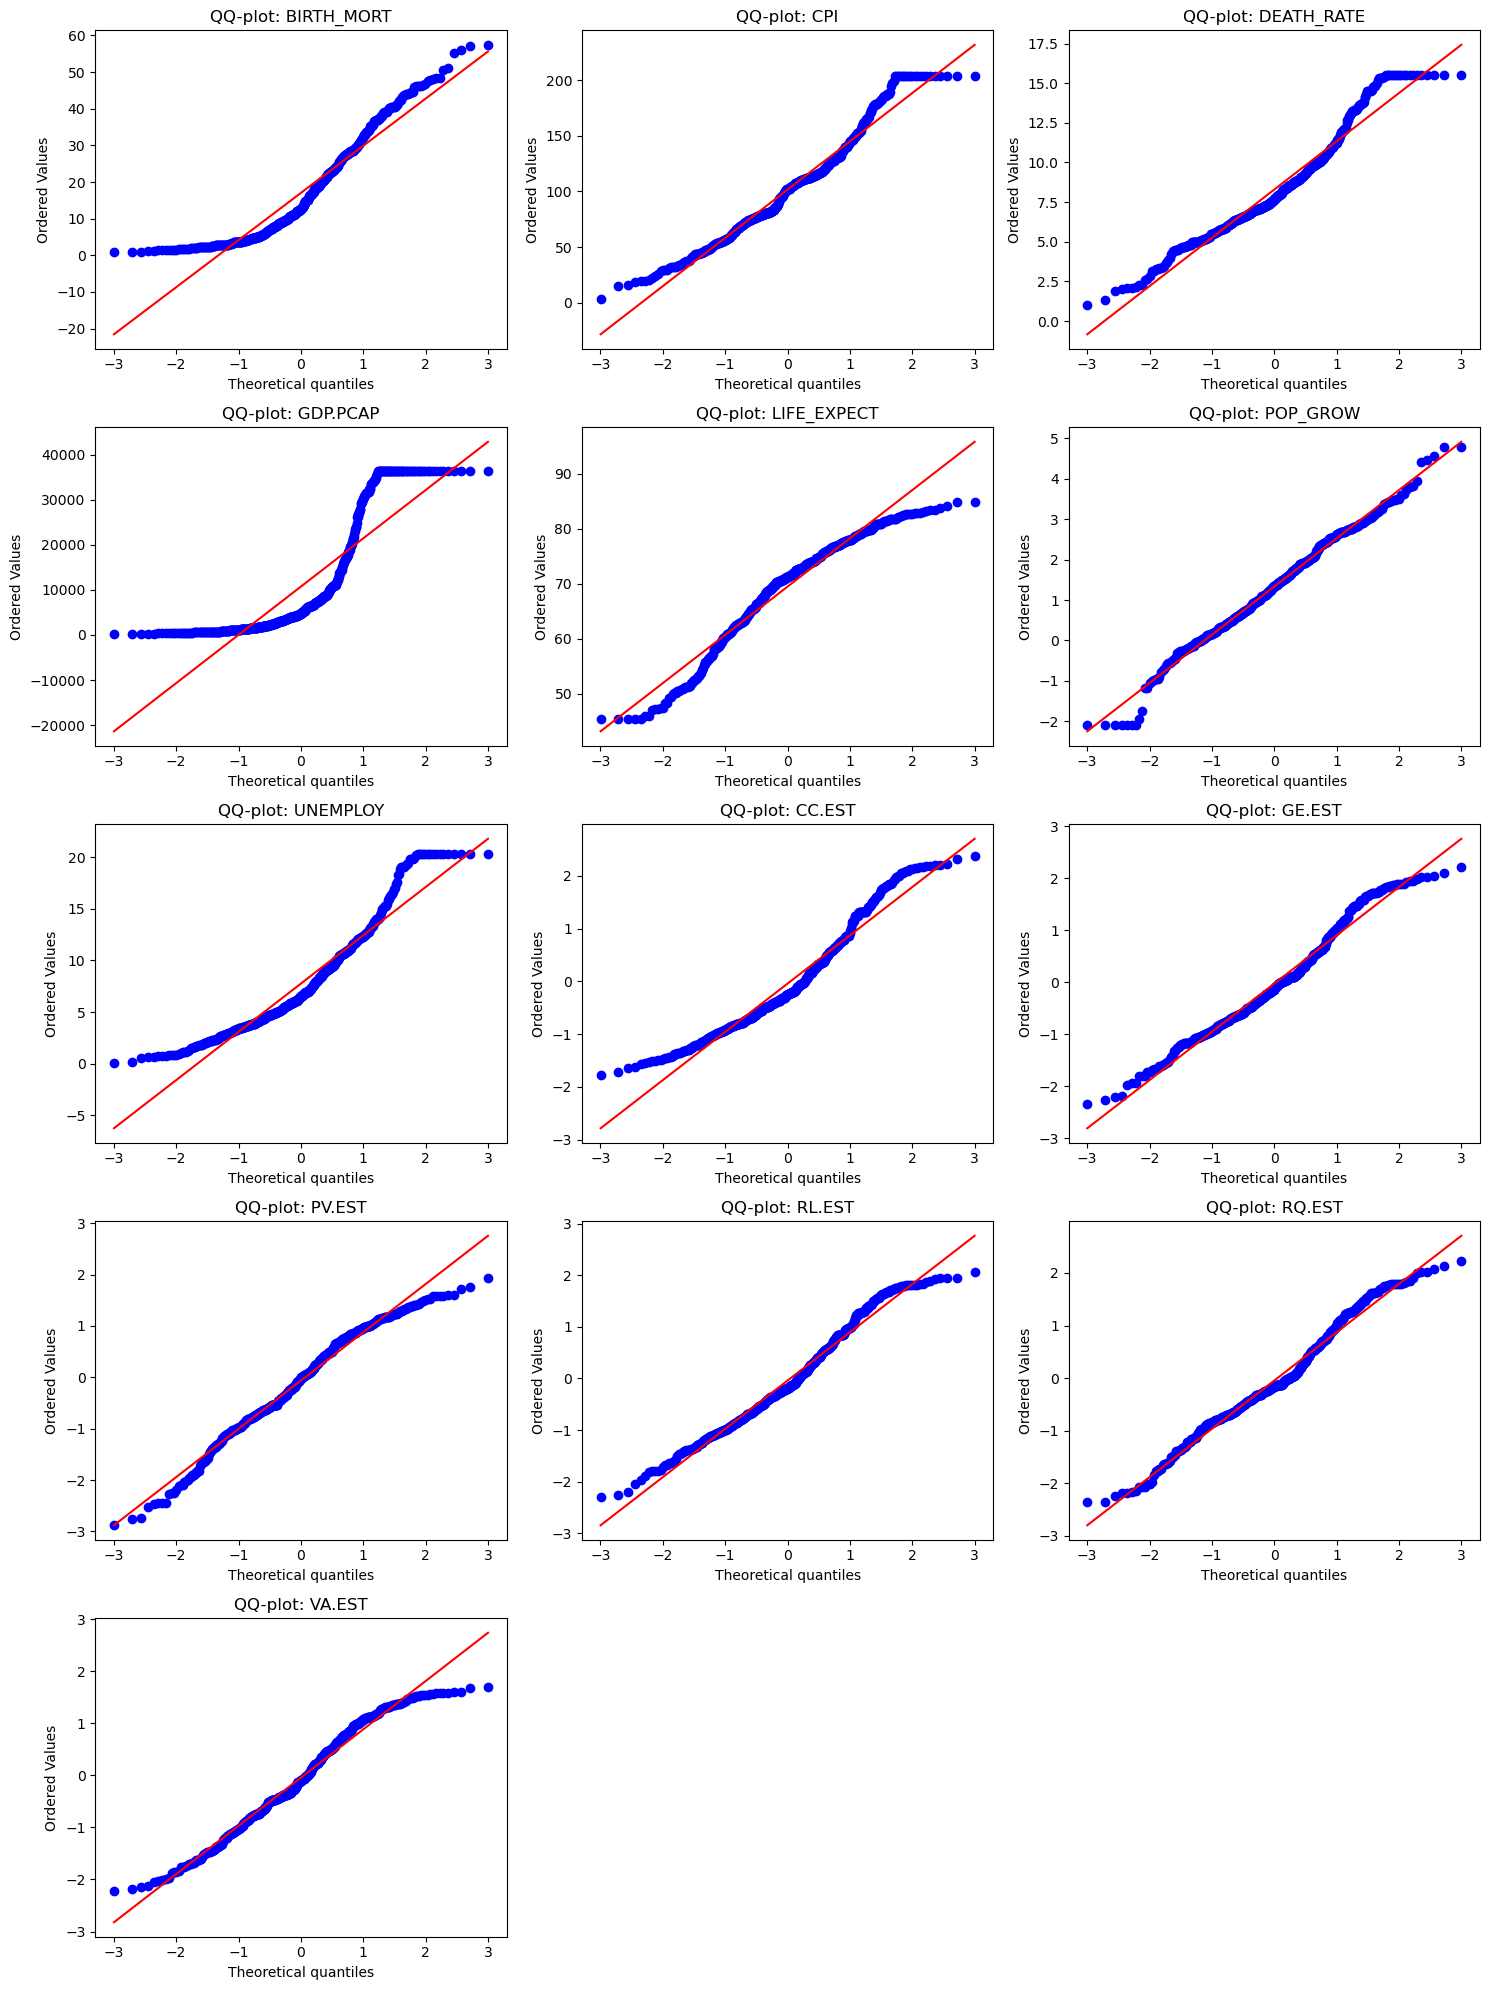

In [28]:
# Lista de columnas seleccionadas (excluyendo las .STD.ERR y variables geogr√°ficas)
reasonable_columns = [
    'BIRTH_MORT', 'CPI', 'DEATH_RATE', 'GDP.PCAP',
    'LIFE_EXPECT', 'POP_GROW', 'UNEMPLOY',
    'CC.EST', 'GE.EST', 'PV.EST', 'RL.EST', 'RQ.EST', 'VA.EST'
]

# Determinar el n√∫mero de filas y columnas para subplots
num_vars = len(reasonable_columns)
cols = 3 # N√∫mero de columnas deseado
rows = math.ceil(num_vars / cols)

# Paso 1: Crear boxplots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=imputed_df[col], color='skyblue')
    plt.title(f"Boxplot: {col}")

plt.tight_layout()
plt.show()

# Paso 2: Crear QQ-plots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    stats.probplot(imputed_df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ-plot: {col}")

plt.tight_layout()
plt.show()

Observamos que se han eliminado los datos problem√°ticos

**Datos err√≥neos**: podemos asumir con los gr√°ficos que no hay valores negativos o nulos

#### 1.3 Interpretaci√≥n de resultados

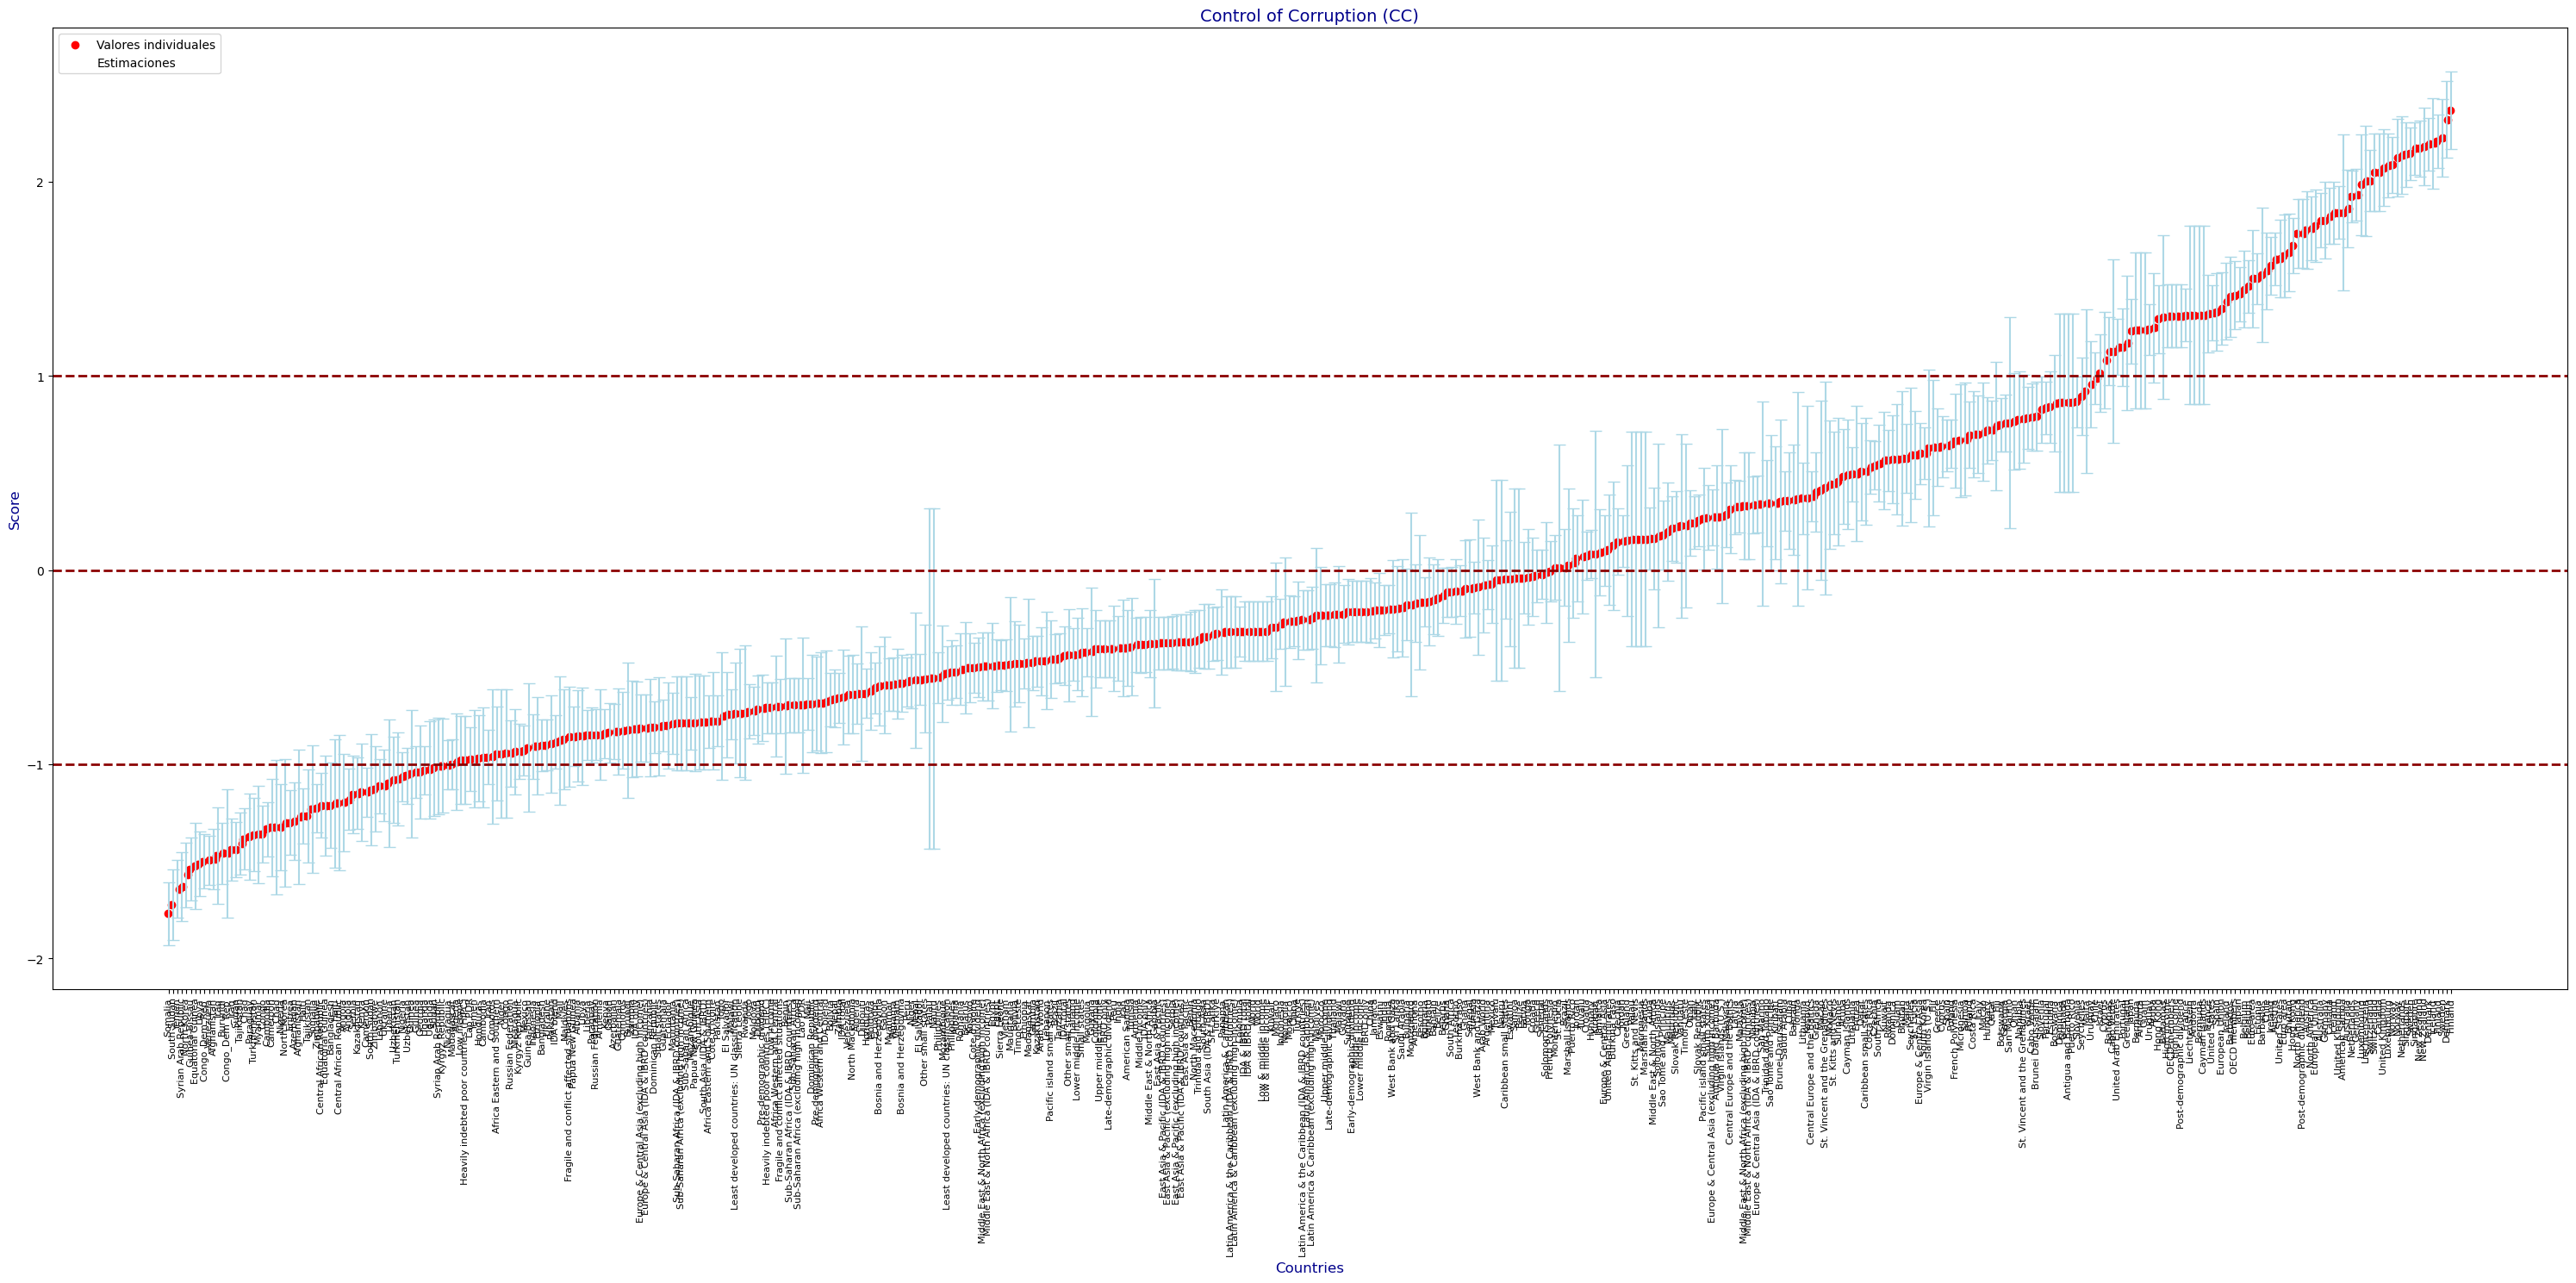

In [29]:
# Filtrar los datos relevantes
cc_data = imputed_df[['Country Name', 'CC.EST', 'CC.STD.ERR']]

# Ordenar los datos por el estimador (CC.EST)
cc_data = cc_data.sort_values(by='CC.EST')

# Crear coordenadas x para las barras
x = np.arange(len(cc_data))
w = 0.8 # Ancho de las barras

# Crear la figura
fig, ax = plt.subplots(figsize=(30, 15))

# Dibujar las barras con barras de error
bars = ax.bar(
    x,
    height=cc_data['CC.EST'],
    yerr=cc_data['CC.STD.ERR'],
    capsize=5,
    width=w,
    color='white',
    edgecolor='white',
    alpha=0.8,
    label='Estimaciones',
    ecolor='lightblue'
)

# Dibujar los puntos sobre las barras, distribuidos aleatoriamente
for i in range(len(x)):
    ax.scatter(
        x[i] + np.random.uniform(-w / 2, w / 2, size=1), # Dispersi√≥n aleatoria en ancho
        [cc_data['CC.EST'].iloc[i]], # Valor de Y
        color='red',
        label='Valores individuales' if i == 0 else "" # Etiqueta solo para el primer punto
    )

# A√±adir l√≠neas horizontales (gu√≠as)
for y in [-1, 0, 1]:
    ax.axhline(y=y, color='darkred', linestyle='--', linewidth=2)

# Configurar etiquetas y t√≠tulo
ax.set_xticks(x) # Ajustar los ticks al √≠ndice de las barras
ax.set_xticklabels(cc_data['Country Name'], rotation=90, fontsize=8) # Alinear etiquetas con las barras
ax.set_title('Control of Corruption (CC)', fontsize=14, color='darkblue')
ax.set_ylabel('Score', fontsize=12, color='darkblue')
ax.set_xlabel('Countries', fontsize=12, color='darkblue')

# A√±adir la leyenda
ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

El gr√°fico ilustra la distribuci√≥n del indicador ‚ÄúControl of Corruption‚Äù (ùê∂ùê∂.ùê∏ùëÜùëá ) para los pa√≠ses del dataset. Cada barra de error representa la incertidumbre en las estimaciones (ùê∂ùê∂.ùëÜùëá ùê∑.ùê∏ùëÖùëÖ) y los valores individuales est√°n resaltados en rojo. Los elementos principales del gr√°fico son: 
1. Valores estimados (ùê∂ùê∂.ùê∏ùëÜùëá ): los puntos rojos representan los valores individuales estimados para cada pa√≠s.
2. Barras de error: muestran la incertidumbre asociada con las estimaciones en ambos sentidos.
3. L√≠neas de referencia: las l√≠neas horizontales en ùê∂ùê∂.ùê∏ùëÜùëá = ‚àí1, ùê∂ùê∂.ùê∏ùëÜùëá = 0, y ùê∂ùê∂.ùê∏ùëÜùëá = 1 act√∫an como puntos de referencia para clasificar la gobernabilidad de cada pa√≠s en t√©rminos de control de la corrupci√≥n.
4. Eje horizontal: los pa√≠ses est√°n ordenados por sus valores de ùê∂ùê∂.ùê∏ùëÜùëá , de menor a mayor, proporcionando una comparaci√≥n clara y estructurada.

**Resultados principales**:
1. Pa√≠ses con bajos valores de ùê∂ùê∂.ùê∏ùëÜùëá : pa√≠ses como Sud√°n, Angola y Yemen tienen valores de ùê∂ùê∂.ùê∏ùëÜùëá por debajo de ‚àí1.5, indicando altos niveles de corrupci√≥n percibida y problemas significativos en el control de la misma. Las barras de error peque√±as para algunos de estos pa√≠ses sugieren que estas estimaciones son confiables.
2. Pa√≠ses con valores intermedios (‚àí1 ‚â§ ùê∂ùê∂.ùê∏ùëÜùëá ‚â§ 0): la mayor√≠a de los pa√≠ses est√°n agrupados en esta categor√≠a, indicando niveles de corrupci√≥n percibida moderados. Ejemplos incluyen Brasil, India, y M√©xico, que a pesar de tener avances en gobernabilidad, a√∫n enfrentan desaf√≠os estructurales significativos.
3. Pa√≠ses con altos valores de ùê∂ùê∂.ùê∏ùëÜùëá (ùê∂ùê∂.ùê∏ùëÜùëá > 1): pa√≠ses como Dinamarca, Noruega, y Singapur destacan por sus altos valores, reflejando sistemas s√≥lidos de control anticorrupci√≥n. Estas naciones pueden considerarse modelos para pol√≠ticas efectivas en gobernabilidad y transparencia.
4. Pa√≠ses con barras de error grandes: algunos pa√≠ses, como Micronesia o Timor-Leste, tienen barras de error relativamente amplias, lo que indica mayor incertidumbre en las estimaciones.

**Tendencias globales**:
1. Distribuci√≥n general: existe una distribuci√≥n continua de valores, con una mayor concentraci√≥n de pa√≠ses en rangos intermedios (‚àí1 ‚â§ ùê∂ùê∂.ùê∏ùëÜùëá ‚â§ 0). Esto sugiere que la mayor√≠a de las naciones enfrentan desaf√≠os de corrupci√≥n, aunque con niveles variados de severidad.
2. Extremos opuestos: los extremos de la gr√°fica muestran claras diferencias entre pa√≠ses altamente corruptos
y aquellos con un fuerte control de la corrupci√≥n. Los pa√≠ses en los extremos pueden ser utilizados como referencias para identificar patrones comunes en gobernabilidad efectiva o inefectiva.

**Conclusi√≥n**: el gr√°fico de ‚ÄúControl of Corruption‚Äù revela importantes disparidades entre pa√≠ses en t√©rminos de control de la corrupci√≥n. Si bien hay una tendencia global hacia valores intermedios, los extremos destacan la urgencia de intervenciones espec√≠ficas en naciones con altos niveles de corrupci√≥n. Por otro lado, los pa√≠ses con valores positivos reflejan sistemas fuertes de gobernabilidad que pueden servir de gu√≠a para pol√≠ticas futuras.

Versi√≥n con **matplotlib**:

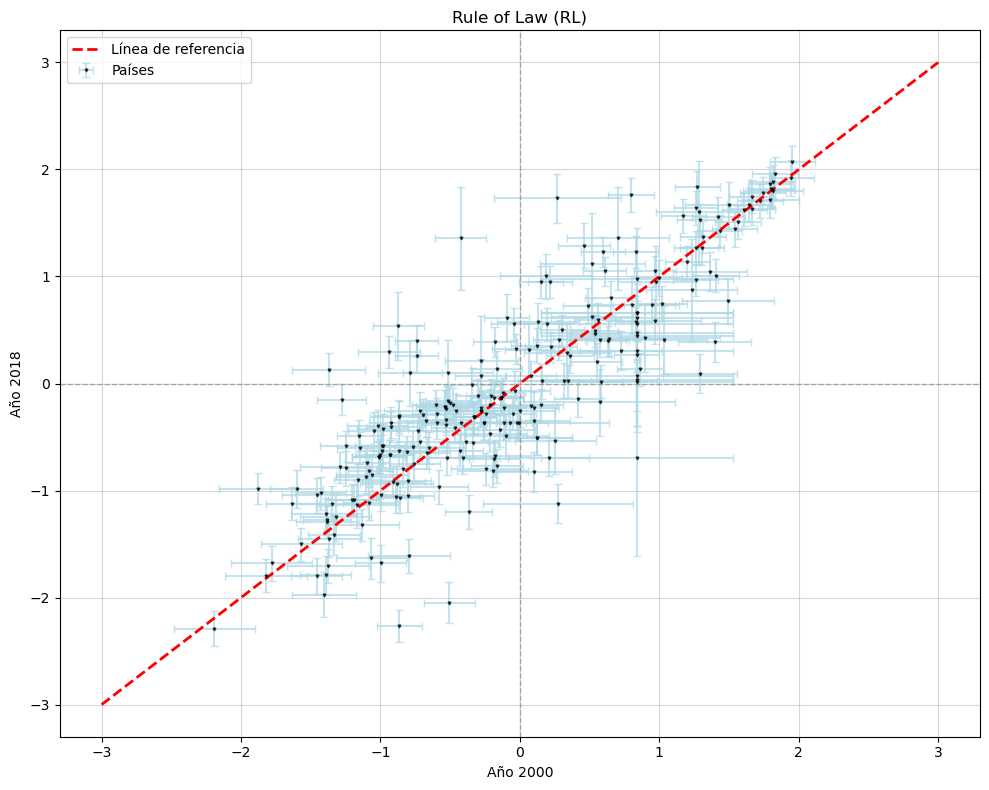

In [30]:
# Filtrar los datos relevantes para Rule of Law (RL)
rl_data = imputed_df[['Country Name', 'RL.EST', 'RL.STD.ERR', 'Year']].dropna()

# Filtrar los a√±os 2000 y 2018
data_2000 = rl_data[rl_data['Year'] == '2000 [YR2000]']
data_2018 = rl_data[rl_data['Year'] == '2018 [YR2018]']

# Hacer un merge para comparar los mismos pa√≠ses en ambos a√±os
merged_rl = pd.merge(
    data_2000[['Country Name', 'RL.EST', 'RL.STD.ERR']],
    data_2018[['Country Name', 'RL.EST', 'RL.STD.ERR']],
    on='Country Name',
    suffixes=('_2000', '_2018')
)

# Crear el gr√°fico
plt.figure(figsize=(10, 8))

# Dibujar puntos individuales con barras de error
plt.errorbar(
    merged_rl['RL.EST_2000'], # Valores del eje X (A√±o 2000)
    merged_rl['RL.EST_2018'], # Valores del eje Y (A√±o 2018)
    xerr=merged_rl['RL.STD.ERR_2000'], # Barras de error en X
    yerr=merged_rl['RL.STD.ERR_2018'], # Barras de error en Y
    fmt='v', # Formato de los puntos
    ecolor='lightblue', # Color de las barras de error
    color='black', # Color de los puntos
    alpha=0.7,
    label='Pa√≠ses',
    ms=2,
    capsize=3
)

# A√±adir una l√≠nea de referencia diagonal
plt.plot(
    [-3, 3], # Rango del eje X
    [-3, 3], # Rango del eje Y
    color='red',
    linestyle='--',
    linewidth=2,
    label='L√≠nea de referencia'
)

# Configurar etiquetas y t√≠tulo
plt.title('Rule of Law (RL)')
plt.xlabel('A√±o 2000')
plt.ylabel('A√±o 2018')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.6) # L√≠nea horizontal en Y=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.6) # L√≠nea vertical en X=0
plt.grid(alpha=0.5)

# A√±adir la leyenda
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

Versi√≥n con **seaborn**:

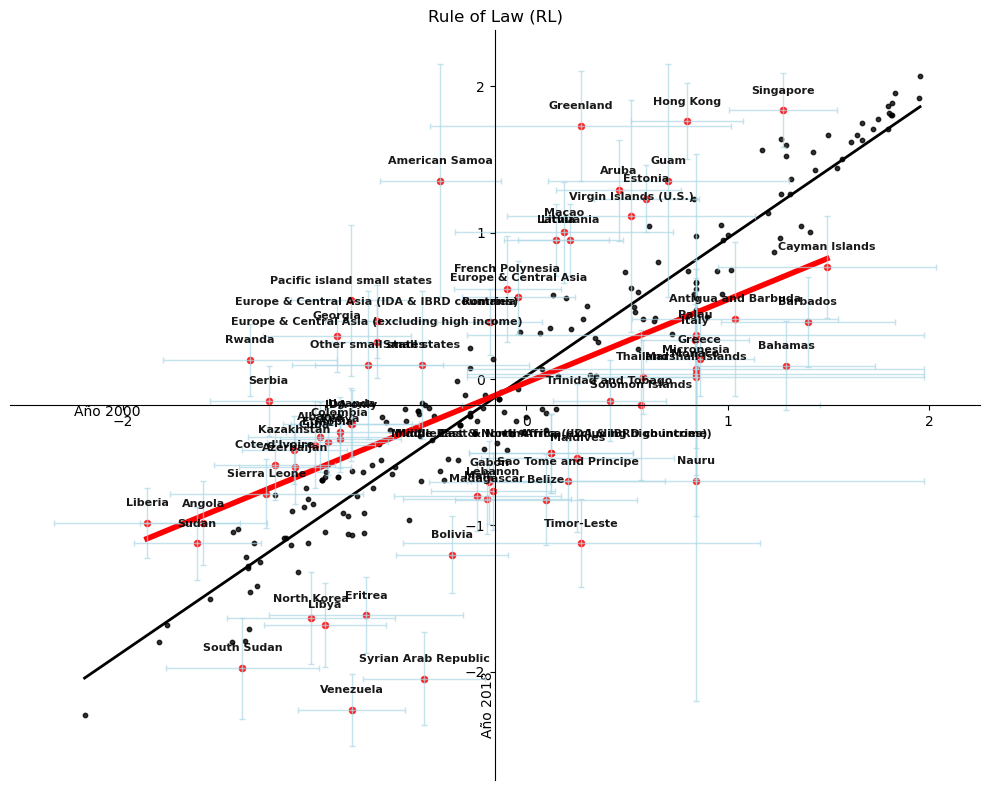

In [31]:
# Calcular residuos (distancia a la l√≠nea diagonal)
merged_rl['Residuals'] = (merged_rl['RL.EST_2018'] - merged_rl['RL.EST_2000']).abs()

# Definir un umbral para determinar "residuos altos" (pa√≠ses alejados de la l√≠nea diagonal)
threshold = 0.5 # Este umbral puede ajustarse seg√∫n el an√°lisis
residuos_altos = merged_rl[merged_rl['Residuals'] > threshold]
residuos_bajos = merged_rl[merged_rl['Residuals'] <= threshold]

# Crear el gr√°fico
plt.figure(figsize=(10, 8))

# Graficar los pa√≠ses con residuos bajos
sns.regplot(
    x='RL.EST_2000',
    y='RL.EST_2018',
    data=residuos_bajos,
    scatter_kws={'color': 'black', 's': 10, 'marker': 's'},
    line_kws={'color': 'black', 'linewidth': 2},
    ci=None
)

# Graficar los pa√≠ses con residuos altos
sns.regplot(
    x='RL.EST_2000',
    y='RL.EST_2018',
    data=residuos_altos,
    scatter_kws={'color': 'red', 's': 20, 'marker': 'D'},
    line_kws={'color': 'red', 'linewidth': 4},
    ci=None
)

# A√±adir etiquetas a los pa√≠ses con residuos altos
z = 1.645 # Intervalo de confianza 90%
for i, row in residuos_altos.iterrows():
    
    # Barras de error
    plt.errorbar(
        x=row['RL.EST_2000'],
        y=row['RL.EST_2018'],
        xerr=row['RL.STD.ERR_2000'] * z,
        yerr=row['RL.STD.ERR_2018'] * z,
        fmt='none',
        ecolor='lightblue',
        elinewidth=1,
        capsize=2,
        alpha=0.7,
    )

    # Etiquetas
    plt.text(
        x=row['RL.EST_2000'],
        y=row['RL.EST_2018'] + 0.1,
        s=row['Country Name'],
        fontsize=8,
        fontweight='bold',
        color='black',
        ha='center',
        va='bottom',
        alpha=0.9
    )

# Configurar los ejes en el centro
plt.gca().spines['left'].set_position('center')
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')

# A√±adir t√≠tulo y etiquetas de los ejes
plt.title("Rule of Law (RL)")
plt.xlabel('A√±o 2000')
plt.ylabel('A√±o 2018')

# Colocar las etiquetas de los ejes correctamente
plt.gca().yaxis.set_label_coords(0.5, 0.1)
plt.gca().xaxis.set_label_coords(0.1, 0.5)

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

El gr√°fico generado compara el indicador Rule of Law (RL.EST) entre los a√±os 2000 y 2018 para los mismos pa√≠ses. Los puntos de dispersi√≥n representan los valores estimados (RL.EST) en cada a√±o, y las barras de error visualizan la incertidumbre asociada con las estimaciones (RL.STD.ERR).
Este an√°lisis sirve para:
- Visualizar cambios: Evaluar c√≥mo ha evolucionado el estado de derecho en diferentes pa√≠ses a lo largo del tiempo.
- Identificar tendencias globales: Una diagonal cercana a ùë¶ = ùë• indicar√≠a poca variaci√≥n entre los a√±os comparados, mientras que desviaciones importantes revelan mejoras o deterioros significativos.
- Considerar la incertidumbre: Las barras de error permiten incluir el margen de incertidumbre en las interpretaciones, evitando conclusiones precipitadas basadas en valores puntuales.

#### Resultados principales
1. Pa√≠ses con mejoras significativas (ùë¶ > ùë•): pa√≠ses como Hong Kong, Singapur y Groenlandia se encuentran notablemente por encima de la l√≠nea diagonal. Esto sugiere que han experimentado mejoras significativas en su estado de derecho entre 2000 y 2018. Estas mejoras pueden deberse a pol√≠ticas espec√≠ficas, estabilidad pol√≠tica o programas de fortalecimiento institucional.
2. Pa√≠ses con deterioros significativos (ùë¶ < ùë•): Sud√°n del Sur, Libia, Eritrea y Venezuela est√°n significativamente por debajo de la l√≠nea diagonal, indicando un fuerte deterioro en su gobernabilidad. Este deterioro podr√≠a atribuirse a conflictos internos, colapso institucional o falta de pol√≠ticas efectivas.
3. Pa√≠ses con barras de error grandes: algunos pa√≠ses, como Sierra Leona y Timor-Leste, tienen barras de error m√°s grandes, lo que indica una alta incertidumbre en las estimaciones. Estos casos deben interpretarse con precauci√≥n, ya que los datos pueden no ser completamente confiables.
4. Tendencia global: la mayor√≠a de los puntos se encuentran cerca de la diagonal, lo que sugiere que los cambios en ùëÖùêø.ùê∏ùëÜùëá han sido modestos a nivel global. Sin embargo, hay un grupo notable de pa√≠ses con residuos altos, destacando la variabilidad en la evoluci√≥n del indicador entre diferentes regiones.

#### Conclusi√≥n
El gr√°fico refleja una tendencia general de estabilidad, con excepciones notables tanto de mejora como de deterioro. Este an√°lisis destaca la importancia de pol√≠ticas espec√≠ficas y contextos regionales en la evoluci√≥n del estado de derecho. Pa√≠ses como Sud√°n y Venezuela representan casos cr√≠ticos, mientras que Hong Kong y Singapur muestran c√≥mo las estrategias acertadas pueden traducirse en avances significativos.